In [1]:
# warnings
import warnings
# time
import time
# data manipulation
import json
import numpy as np
import pandas as pd
import xarray as xr
# geospatial viz
# import folium
# from folium import Choropleth, Circle, Marker, Icon, Popup, FeatureGroup
# from folium.plugins import HeatMap, FastMarkerCluster, MiniMap
# from folium.features import GeoJsonPopup, GeoJsonTooltip

# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches

# geospatial analysis
# import ee
import collections
import geopandas as gpd


# date manipulation
from datetime import timedelta
from datetime import datetime


# windows folder manipulation
import os
import glob

# statistics
import statistics
from statistics import mean
import scipy
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from scipy.stats import zscore

# regressions, metrics and models optimizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
# split database in training and testing data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # randomforest regression
# linear regression or multiple linear regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor  # neural network
from sklearn.svm import SVR  # svm regression
from sklearn.model_selection import cross_validate, GridSearchCV, RepeatedKFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, make_scorer
from xgboost import XGBRegressor

# dataframe storage
import pickle

import model.model_class as model_class

warnings.simplefilter('ignore')

region = "TM"


def func(df, model, transform, wqp):
    # importa os atributos de entrada
    # input_attributes = model.feature_names_in_.tolist()

    # print(f"data: {data.shape} | x: {bands.shape} ")

    # transforma matriz para vetor para realizar operacao
    # stacked = xarray.stack(z=("x", "y"))
    # return stacked
    # seleciona as bandas
    # stacked2[[c for c in xarray.columns if c in loaded_model.feature_names_in_.tolist()]]
    # stacked2 = xarray.sel(bands=loaded_model.feature_names_in_.tolist())
    # print(stacked2.T.shape)
    # print(stacked2.T.values)
    # print(stacked2.T.max())
    # df_temp = stacked2.T.to_dataframe(name = "SIMOA")
    # # return df_temp
    y_pred = model.predict(df.values)  # predicao do modelo
    return y_pred
    # #y_pred_da = xr.DataArray(np.reshape(np.exp(y_pred), (y_pred.shape[0], 1)), dims=("z", "bands"))
    # if transform == 'exp':
    #     y_pred_da = xr.DataArray(np.exp(y_pred), dims=("z"))
    # else:
    #     y_pred_da = xr.DataArray(y_pred, dims=("z"))

    # y_pred_da["bands"] = wqp
    # #y_pred_da.assign_coords({"bands": "Chla"})
    # temp = xr.concat(objs=[stacked.T, y_pred_da], dim='bands')

    # temp = temp.unstack("z")
    # return temp


model_dir = "./best_models/TM_30m"

model_names = [x.split(
    "_")[0] + "_model" for x in os.listdir(model_dir) if not x.startswith(".ipyn")]
model_files = [model_dir + "/" +
               model for model in os.listdir(model_dir) if not model.startswith(".ipyn")]

model_dict = {idx: value for (idx, value) in zip(model_names, model_files)}
data_dir = glob.glob("*-TM")
data_files = []
for i in data_dir:
    data = glob.glob(os.path.join(i, "chl_algo_median_reflectance_30.csv"))
    data_files.append(data)

metadata_files = []
for j in data_dir:
    metadata = glob.glob(os.path.join(j, "metadata.csv"))
    metadata_files.append(metadata)

metadata_df = []
for meta in metadata_files:
    df = pd.read_csv(meta[-1], index_col=None, header=0)
    metadata_df.append(df)


li = []

k = 0
for filename in data_files:
    df = pd.read_csv(filename[-1], index_col=None, header=0)
    df = pd.concat([df, metadata_df[k]], axis=1)
    k += 1
    li.append(df)

# df = df.drop(columns=['Image'])
df = pd.concat(li, axis=0, ignore_index=True)
df = df.drop(columns=['Gimbal Degree'])
if region == "Pampulha":
    df = df.drop(columns=['Degree'])
df = df.drop(columns=['Altitude'])
# df = df.drop(columns=['R/B'])
# df = df.drop(columns=['R^2/B'])
# df = df.drop(columns=['MLR'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)
df.dropna(inplace=True)
df['R^2/NIR'] = pd.to_numeric(
    df['R^2/NIR'], downcast='float')
df['R^2/RE'] = pd.to_numeric(
    df['R^2/RE'], downcast='float')
df['R^2/B'] = pd.to_numeric(
    df['R^2/B'], downcast='float')
df['MLR'] = pd.to_numeric(
    df['MLR'], downcast='float')

model_selected = pd.read_csv("./best_models/TM_30m/model_selected.csv")
model_dict.pop("model_model")
x = 0
for i in model_dict:
    df_to_predict = df
    x += 1

    filename = model_dict[i]
    loaded_model = pickle.load(open(filename, 'rb'))
    print(filename)
    model_name = filename.split('/')
    model_name = model_name[-1].split('_')
    model_linear = model_name[2]
    if model_linear == "LinearRegression":  # Para a pampulha não mudou sozinho para NDVI, a unica feature do modelo LinearRegression, entao coloquei isso aqui
        # hard coded so para poder rolar, tem maneiras melhores de fazer isso though
        df_to_predict = df_to_predict["NDVI"]
        df_to_predict = df_to_predict.to_frame(name="NDVI")

    if i == 'secchi_model':
        wqp = 'Secchi (cm)'
        transform = 'linear'
    elif i == 'fdom_model':
        wqp = 'Fdom (fnu)'
        transform = 'linear'
    elif i == 'pc_model':
        wqp = 'PC (rfu)'
        transform = 'linear'
    elif i == 'chl_model':
        wqp = 'Chl (rfu)'
        transform = 'log'
    elif i == 'turb_model':
        wqp = 'Turb (fnu)'
        transform = 'linear'
    if transform == 'log':
        df_to_predict = df_to_predict.apply(lambda x: np.log(
            x) if np.issubdtype(x.dtype, np.number) else x)
    elif transform == 'poly':
        poly = PolynomialFeatures(degree=2)
        df_to_predict = poly.fit_transform(df_to_predict.values)
    elif transform == 'exp':
        df_to_predict = df_to_predict.apply(lambda x: np.exp(
            x) if np.issubdtype(x.dtype, np.number) else x)
    if region == "TM":
        if i != 'fdom_model' and i != 'turb_model':
            df_to_predict = df_to_predict[[
                c for c in df_to_predict.columns if c in loaded_model.feature_names_in_.tolist()]]
    elif region == "Pampulha":
        if i != "secchi_model":
            df_to_predict = df_to_predict[[
                c for c in df_to_predict.columns if c in loaded_model.feature_names_in_.tolist()]]
    elif i == 'fdom_model' or i == 'chl_model':
        df_to_predict['R^2/NIR'] = pd.to_numeric(
            df_to_predict['R^2/NIR'], downcast='float')
        df_to_predict['R^2/RE'] = pd.to_numeric(
            df_to_predict['R^2/RE'], downcast='float')
        df_to_predict['R^2/B'] = pd.to_numeric(
            df_to_predict['R^2/B'], downcast='float')
        df_to_predict['MLR'] = pd.to_numeric(
            df_to_predict['MLR'], downcast='float')
    print(i)
    print(model_name[2])
    indices_to_keep = ~df_to_predict.isin([np.nan, np.inf, -np.inf]).any(1)
    df_to_predict = df_to_predict[indices_to_keep]
    print("Colunas sendo passadas para o modelo")
    print(df_to_predict.columns)
    print(df_to_predict.shape)
    df_to_predict = df_to_predict.reset_index()
    predict_df = func(df_to_predict, loaded_model, 'exp', wqp)
    df[wqp + ' ' + model_name[2]] = predict_df
# df.to_csv("TM_models_30M_0.3.csv")


# for i in data_dir:
#     file_path = os.path.join(i, "chl_algo_median_reflectance_30.csv")
#     df.to_csv(file_path)

# filename = model_dict.get('secchi_model')
# loaded_model = pickle.load(open(filename, 'rb'))

# print(loaded_model.feature_names_in_)


./best_models/TM_30m/chl_rfu_XGBRegressor_log.pkl
chl_model
XGBRegressor
Colunas sendo passadas para o modelo
Index(['Blue', 'Green', 'Kab 1(Rs)', 'B3B1', 'GB1'], dtype='object')
(9418, 5)


ValueError: Feature shape mismatch, expected: 5, got 6

## METODO

In [53]:
def func(df, model, attributes, transform, wqp):
    '''
    Metodo para a aplicação dos modelos nas medianas das imagens
    
    Input
    -------------
    df: pandas.DataFrame
        dataframe with data
    model: sklearn.Model
        model stored and opened from pickle file
    attributes: list
        list of strings with attributes that fit the model
    transform: str
        type of transformation performed in the data
    wqp: str
        water quality parameter
        
    Return
    -------------
    df: pandas.DataFrame
        same entered dataframe but with modeled wqp concatenated along the y-axis
    '''
    
    X = df.loc[:, attributes]

    if transform == 'linear' or transform == 'exp':
        X = X
    elif transform == 'poly':
        poly = PolynomialFeatures(degree = 2)
        X = poly.fit_transform(X)
    elif transform == 'log':
        X = np.log(X)
    else:
        raise NameError('You probably forgot to enter a type. The types possible are: linear, poly, exp, poly, standard_scaler, min_max')
    
    
    y_pred = model.predict(X)
    
    if transform == 'exp':
        y_pred = np.log(y_pred)
    else:
        pass
    
    df.loc[:, wqp + "_modeled"] = y_pred
    
    return df

## IMPORT DATAFRAME

In [7]:
df = pd.read_csv('field_data_Campo2022-03-10-Pampulha/chl_algo_median_reflectance_30.csv')
metadata = pd.read_csv('field_data_Campo2022-03-10-Pampulha/metadata.csv')
print(df.head())
print(metadata.head())

       Blue     Green       Red   Near-IR   RedEdge                   Image  \
0  0.108920  0.200351  0.212927  0.095720  0.155505  0000SET_000_DJI_3471.T   
1  0.107692  0.196801  0.206819  0.093393  0.152122  0000SET_000_DJI_3481.T   
2  0.107175  0.197205  0.201498  0.090747  0.147213  0000SET_000_DJI_3491.T   
3  0.106791  0.196116  0.198665  0.089998  0.146330  0000SET_000_DJI_3501.T   
4  0.107730  0.198416  0.202270  0.091180  0.148678  0000SET_000_DJI_3511.T   

        R^2/NIR        R^2/RE         R^2/B  R/B  ...      SABI      NDCI  \
0  1.714915e+11  1.328460e+08  1.533710e+12  inf  ... -0.185668 -0.379745   
1  7.294916e+10  6.830098e+07  4.243088e+11  inf  ... -0.179632 -0.377820   
2  4.091906e+10  4.835668e+07  1.231059e+11  inf  ... -0.178344 -0.378967   
3  2.520971e+10  3.273678e+07  6.599886e+10  inf  ... -0.172777 -0.376452   
4  4.391256e+10  4.647453e+07  1.311961e+11  inf  ... -0.175055 -0.378564   

       NDVI    2BDA_1    2BDA_2    3BDA_1  3BDA_MOD      B3B1 

In [8]:
print(df.shape, metadata.shape)

(570, 23) (570, 6)


In [10]:
df_f = pd.concat([df, metadata], axis = 1)
df_f.head()

,Blue,Green,Red,Near-IR,RedEdge,Image,R^2/NIR,R^2/RE,R^2/B,R/B,...,3BDA_MOD,B3B1,GB1,GR,Latitude,Longitude,Altitude,Gimbal Degree,DateTime,Image Index
0,0.108920,0.200351,0.212927,0.095720,0.155505,0000SET_000_DJI_3471.T,1.714915e+11,1.328460e+08,1.533710e+12,inf,...,-1.266076,0.295634,1.839433,0.940936,-19.851245,-43.976024,836.708,90.0,2022:03:10 06:33:10,_Campo20220310-Pampulha_0000SET_000_DJI_3471.TIF
1,0.107692,0.196801,0.206819,0.093393,0.152122,0000SET_000_DJI_3481.T,7.294916e+10,6.830098e+07,4.243088e+11,inf,...,-1.421722,0.292648,1.827446,0.951565,-19.851069,-43.975989,836.555,89.9,2022:03:10 06:33:17,_Campo20220310-Pampulha_0000SET_000_DJI_3481.TIF
2,0.107175,0.197205,0.201498,0.090747,0.147213,0000SET_000_DJI_3491.T,4.091906e+10,4.835668e+07,1.231059e+11,inf,...,-1.689185,0.295779,1.840019,0.978696,-19.850772,-43.975928,835.937,90.0,2022:03:10 06:33:27,_Campo20220310-Pampulha_0000SET_000_DJI_3491.TIF
3,0.106791,0.196116,0.198665,0.089998,0.146330,0000SET_000_DJI_3501.T,2.520971e+10,3.273678e+07,6.599886e+10,inf,...,-1.747300,0.294894,1.836453,0.987168,-19.850543,-43.975884,835.928,89.9,2022:03:10 06:33:37,_Campo20220310-Pampulha_0000SET_000_DJI_3501.TIF
4,0.107730,0.198416,0.202270,0.091180,0.148678,0000SET_000_DJI_3511.T,4.391256e+10,4.647453e+07,1.311961e+11,inf,...,-1.684828,0.296217,1.841784,0.980945,-19.850498,-43.975885,835.905,90.0,2022:03:10 06:33:41,_Campo20220310-Pampulha_0000SET_000_DJI_3511.TIF


# read chla model

In [20]:
df_models = pd.read_csv('best_models/Pampulha_10m/model_selected.csv')
df_models.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,type,model,class,attributes,target,params,train_test_rs,...,mean_train_RMSE,mean_test_RMSE,validation_RMSE,baseline_RMSE,mean_train_NRMSE (%),mean_test_NRMSE (%),validation_NRMSE (%),baseline_NRMSE (%),Unnamed: 0.1.1.1,model_dir
0,72,72,13,linear,LinearRegression,Univariate,NDVI,secchi_cm,{'positive': False},4,...,16.80,16.86,27.24,24.48,36.58,36.92,55.0,53.0,NaN,best_models/Pampulha_10m/secchi_cm_LinearRegre...
1,455,185,95,log,RandomForestRegressor,Multivariate,"Blue, Green, Red, RedEdge, Near-IR",chl_rfu,"{'criterion': 'squared_error', 'max_depth': 50...",4,...,0.79,2.03,1.05,5.10,9.42,24.50,12.0,60.0,3.0,best_models/Pampulha_10m/chl_rfu_RandomForestR...
2,684,194,104,linear,XGBRegressor,Multivariate,"Blue, Green, Red, RedEdge, Near-IR",pc_rfu,"{'max_depth': 25, 'n_estimators': 50}",4,...,0.07,1.66,1.43,3.84,0.87,23.03,18.0,52.0,0.0,best_models/Pampulha_10m/pc_rfu_XGBRegressor_l...
3,866,156,84,linear,XGBRegressor,Multivariate,"Blue, Green, Red, RedEdge, Near-IR",fdom_rfu,"{'max_depth': 2, 'n_estimators': 50}",4,...,0.30,0.99,0.68,2.39,3.24,10.78,7.0,26.0,0.0,best_models/Pampulha_10m/fdom_rfu_XGBRegressor...
4,1146,258,136,linear,XGBRegressor,Multivariate,"Blue, Green, Red, RedEdge, Near-IR",turb_fnu,"{'max_depth': 25, 'n_estimators': 10}",4,...,3.44,11.87,4.70,19.69,11.93,41.23,15.0,68.0,0.0,best_models/Pampulha_10m/turb_fnu_XGBRegressor...


In [71]:
wqp_list = list(df_models['target'].unique())
wqp_list

['secchi_cm', 'chl_rfu', 'pc_rfu', 'fdom_rfu', 'turb_fnu']

secchi_cm
Attributes na planilha: ['NDVI']
Transform: linear
chl_rfu
Attributes na planilha: ['Blue', 'Green', 'Red', 'RedEdge', 'Near-IR']
Transform: log
pc_rfu
Attributes na planilha: ['Blue', 'Green', 'Red', 'RedEdge', 'Near-IR']
Transform: linear
fdom_rfu
Attributes na planilha: ['Blue', 'Green', 'Red', 'RedEdge', 'Near-IR']
Transform: linear
turb_fnu
Attributes na planilha: ['Blue', 'Green', 'Red', 'RedEdge', 'Near-IR']
Transform: linear


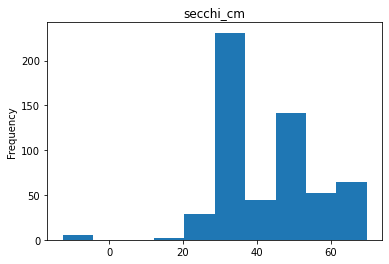

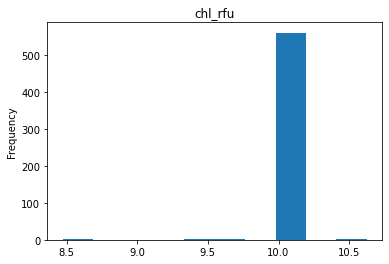

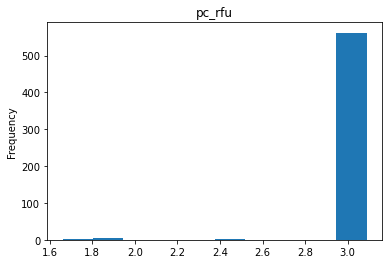

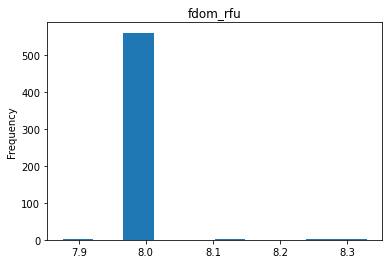

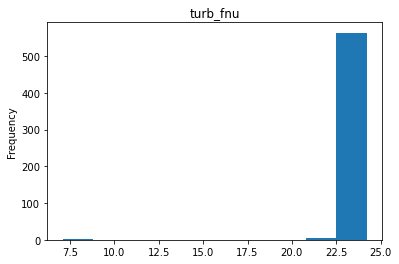

In [76]:
for wqp in wqp_list:
    fig, ax = plt.subplots(1, 1)
    print(wqp)
    filename = df_models.loc[df_models['target']==wqp, 'model_dir'].values[0]
    loaded_model = pickle.load(open(str(filename), 'rb'))
    #print("Attributes no modelo: {}".format(loaded_model.feature_names_in_))
    attributes = df_models.loc[df_models['target']==wqp, 'attributes'].squeeze().split(", ")
    print("Attributes na planilha: {}".format(attributes))
    transform = df_models.loc[df_models['target']==wqp, 'type'].values[0]
    print("Transform: {}".format(transform))
    df_f = func(df_f, loaded_model, attributes, transform, wqp)
    df_f.loc[:, wqp+'_modeled'].plot(kind='hist', ax=ax)
    plt.title(wqp)
    

In [56]:
teste

,Blue,Green,Red,Near-IR,RedEdge,Image,R^2/NIR,R^2/RE,R^2/B,R/B,...,GB1,GR,Latitude,Longitude,Altitude,Gimbal Degree,DateTime,Image Index,chl_rfu,chl_rfu_modeled
0,0.108920,0.200351,0.212927,0.095720,0.155505,0000SET_000_DJI_3471.T,1.714915e+11,1.328460e+08,1.533710e+12,inf,...,1.839433,0.940936,-19.851245,-43.976024,836.708,90.0,2022:03:10 06:33:10,_Campo20220310-Pampulha_0000SET_000_DJI_3471.TIF,9.4986,9.4986
1,0.107692,0.196801,0.206819,0.093393,0.152122,0000SET_000_DJI_3481.T,7.294916e+10,6.830098e+07,4.243088e+11,inf,...,1.827446,0.951565,-19.851069,-43.975989,836.555,89.9,2022:03:10 06:33:17,_Campo20220310-Pampulha_0000SET_000_DJI_3481.TIF,9.5375,9.5375
2,0.107175,0.197205,0.201498,0.090747,0.147213,0000SET_000_DJI_3491.T,4.091906e+10,4.835668e+07,1.231059e+11,inf,...,1.840019,0.978696,-19.850772,-43.975928,835.937,90.0,2022:03:10 06:33:27,_Campo20220310-Pampulha_0000SET_000_DJI_3491.TIF,8.5320,8.5320
3,0.106791,0.196116,0.198665,0.089998,0.146330,0000SET_000_DJI_3501.T,2.520971e+10,3.273678e+07,6.599886e+10,inf,...,1.836453,0.987168,-19.850543,-43.975884,835.928,89.9,2022:03:10 06:33:37,_Campo20220310-Pampulha_0000SET_000_DJI_3501.TIF,8.4716,8.4716
4,0.107730,0.198416,0.202270,0.091180,0.148678,0000SET_000_DJI_3511.T,4.391256e+10,4.647453e+07,1.311961e+11,inf,...,1.841784,0.980945,-19.850498,-43.975885,835.905,90.0,2022:03:10 06:33:41,_Campo20220310-Pampulha_0000SET_000_DJI_3511.TIF,8.5320,8.5320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0.865763,2.663430,3.525590,2.553688,3.931924,0000SET_000_DJI_9831.T,2.795940e+115,1.202656e+88,inf,inf,...,3.076396,0.755456,-19.852346,-43.969563,841.851,69.6,2022:03:10 10:29:16,_Campo20220310-Pampulha_0000SET_000_DJI_9831.TIF,10.1426,10.1426
566,0.904229,2.553877,3.709196,1.165059,2.116466,0000SET_000_DJI_9841.T,1.228599e+280,1.319989e+181,inf,inf,...,2.824370,0.688526,-19.852739,-43.968736,843.539,62.9,2022:03:10 10:29:57,_Campo20220310-Pampulha_0000SET_000_DJI_9841.TIF,10.1426,10.1426
567,0.874132,2.521356,3.629738,1.117890,1.939952,0000SET_000_DJI_9851.T,3.430401e+279,1.679848e+189,inf,inf,...,2.884410,0.694639,-19.852739,-43.968734,843.763,62.9,2022:03:10 10:29:59,_Campo20220310-Pampulha_0000SET_000_DJI_9851.TIF,10.1426,10.1426
568,0.883509,2.621017,3.563375,2.643089,2.084398,0000SET_000_DJI_9861.T,8.816199e+113,5.385774e+169,inf,inf,...,2.966600,0.735543,-19.852739,-43.968735,843.626,62.9,2022:03:10 10:30:02,_Campo20220310-Pampulha_0000SET_000_DJI_9861.TIF,10.1426,10.1426


<AxesSubplot:ylabel='Frequency'>

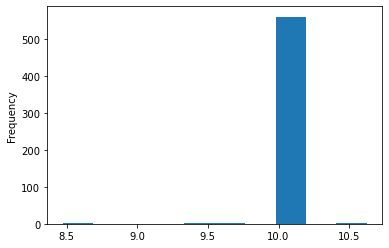

In [57]:
teste.loc[:, 'chl_rfu_modeled'].plot(kind='hist')

In [60]:
gdf = gdf.read_teste.Latitude

0     -19.851245
1     -19.851069
2     -19.850772
3     -19.850543
4     -19.850498
         ...    
565   -19.852346
566   -19.852739
567   -19.852739
568   -19.852739
569   -19.852738
Name: Latitude, Length: 570, dtype: float64

In [61]:
gdf = gpd.GeoDataFrame(teste, geometry=gpd.points_from_xy(teste.Longitude, teste.Latitude))

<AxesSubplot:>

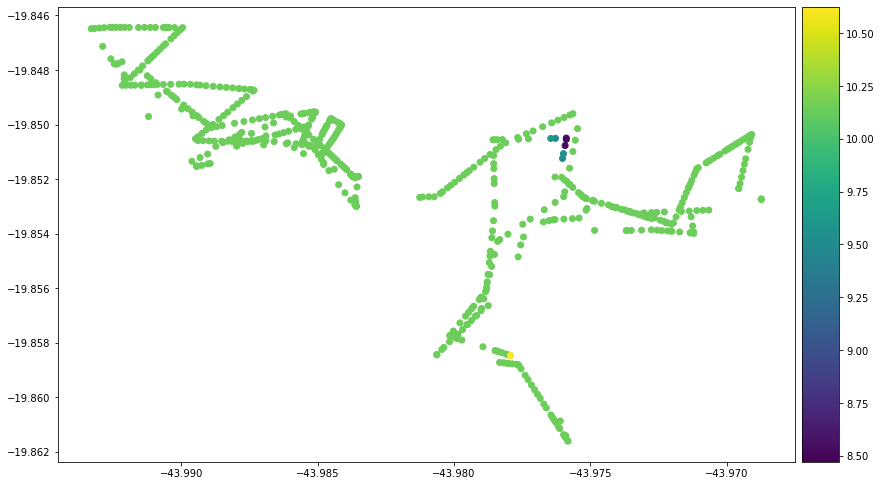

In [69]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(14, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot(column='chl_rfu_modeled', ax=ax, cax=cax, legend=True)
